In [6]:
# imports
import sys

sys.path.append( '../FIA' )
sys.path.append( '../ML' )
sys.path.append( '..' )
from helpers import *
from FIA import *
from ML4com import *
from DL4com import *

In [2]:
# Load matrices
mat_to_tsv_batch("../../data/comm8_0")

strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")
metData = pd.read_csv("../../data/comm8_0/metData.tsv", sep="\t")
metData.index = pd.read_csv("../../data/comm8_0/metName.tsv", sep="\t")

met_raw_pos = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")
met_raw_comb = pd.concat( [total_ion_count_normalization( join_df_metNames(met_raw_pos) ),
                           total_ion_count_normalization( join_df_metNames(met_raw_neg) )] )

In [3]:
# Define data
X = met_raw_comb.transpose()
ys = comm8

## Model

### Hyperparameter optimization

In [4]:
configuration_space = ConfigurationSpace()
max_layers = 5
dropout_in = Float("dropout_in", (0.0, 0.8), default=0.5)

n_layers = Integer("n_layers", (1, max_layers), default=1)
n_neurons = []
activations = []
dropouts =[]
for i in range(max_layers):
    n_neurons.append(Integer(f"n_neurons_{i}", (10, 1000), log=True, default=10))
    activations.append( Categorical(f"activation_{i}", ["tanh", "relu", "leakyrelu", "sigmoid"], default="relu") )
    dropouts.append( Categorical(f"dropout_{i}", [True, False], default=True) )

solver = Categorical("solver", ["nadam"], default="nadam")
learning_rate = Float("learning_rate", (1e-3, 1e-1), log=True, default=1e-2)

hyperparameters = n_neurons + activations + dropouts + [dropout_in, n_layers, solver, learning_rate]
configuration_space.add_hyperparameters(hyperparameters)

[n_neurons_0, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 n_neurons_1, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 n_neurons_2, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 n_neurons_3, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 n_neurons_4, Type: UniformInteger, Range: [10, 1000], Default: 10, on log-scale,
 activation_0, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_1, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_2, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_3, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_4, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 dropout_0, Type: Categorical, Choices: {True, False}, Default: True,
 dropout_1, Type: Categorical, Choices: {True, False}, Defau

In [7]:
outdir = Path(os.path.normpath("../../runs/ML/NN/smac"))
classifier = classifier(X, ys, test_size=0.2, configuration_space=configuration_space, model_builder=build_classification_model, model_args={"multiclass":True})

# Define our environment variables
scenario = Scenario( classifier.configspace, n_trials=1000,
                    min_budget=5, max_budget=100,
                    n_workers=1, output_directory=outdir,
                    walltime_limit=3600, cputime_limit=np.inf, trial_memory_limit=6000000000    # Max RAM in Bytes (not MB)
                    )

initial_design = MultiFidelityFacade.get_initial_design(scenario, n_configs=100)

intensifier = Hyperband(scenario, incumbent_selection="highest_budget")

# Create our SMAC object and pass the scenario and the train method
smac = MultiFidelityFacade( scenario, classifier.train, 
                           initial_design=initial_design, intensifier=intensifier,
                           overwrite=False, logging_level=20
                           )

[INFO][abstract_initial_design.py:147] Using 100 initial design configurations and 0 additional configurations.


In [8]:
tf.config.threading.set_inter_op_parallelism_threads(1)
incumbent = smac.optimize()

[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 5, and max budget 100.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [11.11111111111111, 33.33333333333333, 100.0]
[INFO][successive_halving.py:329] --- Bracket 1: [33.33333333333333, 100.0]
[INFO][successive_halving.py:329] --- Bracket 2: [100.0]
[INFO][abstract_intensifier.py:515] Added config f7d7a3 as new incumbent because there are no incumbents yet.


KeyboardInterrupt: 

### Return best

In [ ]:
incumbent_cost = smac.validate(incumbent)
print(f"Incumbent cost of continued run: {incumbent_cost}")

Incumbent cost of continued run: 0.2857142686843872


In [ ]:
results = pd.DataFrame(columns=["config_id", "config", "instance", "budget", "seed", "loss", "time", "status", "additional_info"])
for trial_info, trial_value in smac.runhistory.items():
    results.loc[len(results.index)] = [trial_info.config_id, dict(smac.runhistory.get_config(1)), trial_info.instance,
                                       trial_info.budget, trial_info.seed,
                                       trial_value.cost, trial_value.time, trial_value.status, trial_value.additional_info]
results

,config_id,config,instance,budget,seed,accuracy,time,status,additional_info
0,1,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,1.771528,1,{}
1,2,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,2.583583,1,{}
2,3,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.642857,2.567701,1,{}
3,4,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.642857,2.753785,1,{}
4,5,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.071429,2.586906,1,{}
...,...,...,...,...,...,...,...,...,...
995,771,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,1.265428,1,{}
996,772,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,1.294266,1,{}
997,773,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.571429,1.617099,1,{}
998,774,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.000000,1.972116,1,{}


### Classification

In [ ]:
metrics_df = cross_validate_model(X, ys, build_classification_model(config=incumbent, multiclass=False),
								  fold=KFold(n_splits=5), patience=1000, epochs=100000,
								  verbosity=0)

  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step - loss: 9.7909e-04 - accuracy: 1.0000
[WARNING][polymorphic_function.py:156] 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fad91364360> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 [==============================] - 0s 47ms/step
[WARNING][polymorphic_function.py:156] 5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7fad91367

 12%|█▎        | 1/8 [01:29<10:29, 89.90s/it]

[WARNING][polymorphic_function.py:156] 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fad902982c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 [==============================] - 0s 46ms/step
[WARNING][polymorphic_function.py:156] 6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7fad9029b6a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tra

 25%|██▌       | 2/8 [03:18<10:05, 100.90s/it]

1/1 [==============================] - 0s 79ms/step - loss: 0.0015 - accuracy: 1.0000


 38%|███▊      | 3/8 [04:56<08:17, 99.42s/it] 

1/1 [==============================] - 0s 80ms/step - loss: 0.1725 - accuracy: 0.9231


 50%|█████     | 4/8 [06:04<05:47, 86.96s/it]

1/1 [==============================] - 0s 80ms/step - loss: 0.2469 - accuracy: 0.8462


 62%|██████▎   | 5/8 [07:20<04:09, 83.02s/it]

1/1 [==============================] - 0s 84ms/step - loss: 2.0398 - accuracy: 0.6923


 75%|███████▌  | 6/8 [09:25<03:14, 97.38s/it]

1/1 [==============================] - 0s 94ms/step - loss: 6.1388 - accuracy: 0.3077


 88%|████████▊ | 7/8 [11:39<01:49, 109.26s/it]

1/1 [==============================] - 0s 87ms/step - loss: 1.7525 - accuracy: 0.7692


100%|██████████| 8/8 [13:13<00:00, 99.23s/it] 


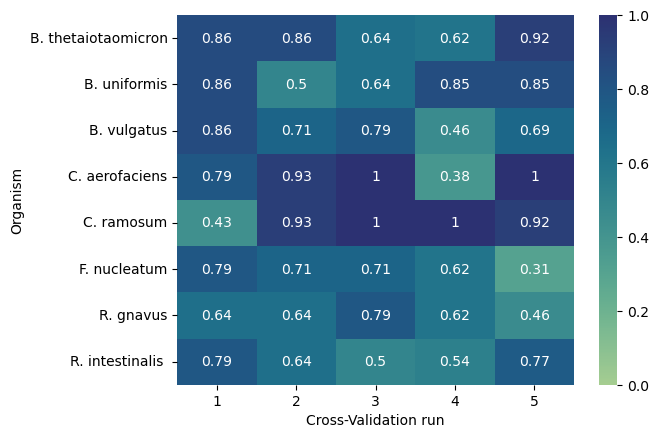

In [ ]:
# Accuracy CV matrix
ax = sns.heatmap(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy"),
                 vmin=0, vmax=1.0, annot=True, cmap=sns.color_palette("crest", as_cmap=True))

FileNotFoundError: [Errno 2] No such file or directory: '../../runs/ML/try/NN/class_annot_test_2.png.png'

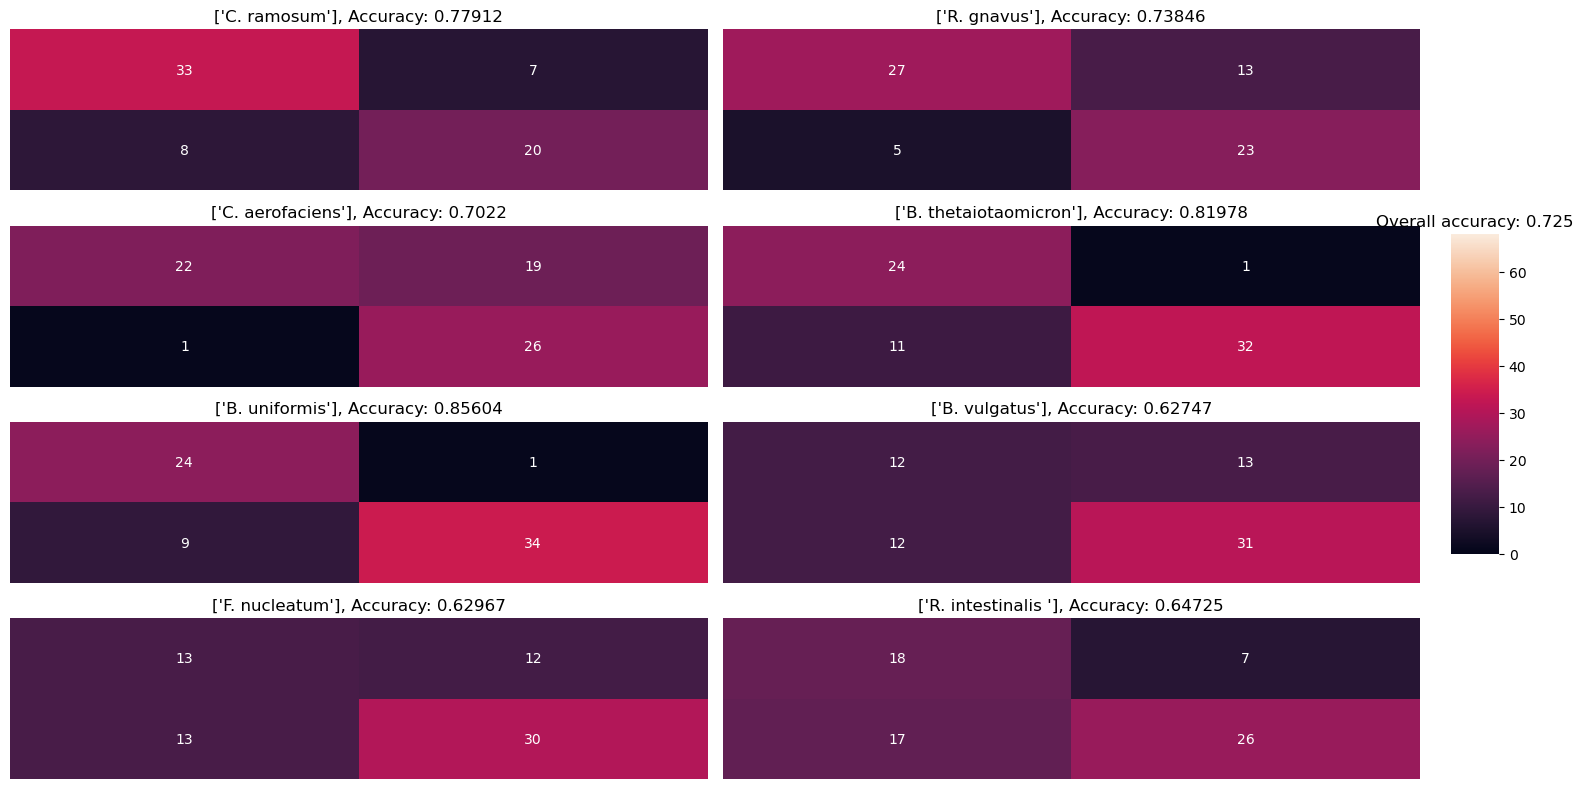

In [ ]:
plot_cv_confmat(ys=ys, target_labels=strains.values,
                accuracies=np.mean(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy").values, axis=1),
                confusion_matrices=np.sum(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Conf_Mat").values, axis=1),
				outdir="../../runs/ML/try/NN", name="class_annot_test_2.png")